Neural ODEs for supervised learning and generative models

From-scratch implementation of "Neural Ordinary Differential Equations" (Chen et al., 2019), reproducing results from the paper and experimenting.

In [1]:
import math
import numpy as np
#from IPython.display import clear_output
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable


In [2]:
use_cuda = torch.cuda.is_available()

Step 1. Implementation of an ODE solver

In [3]:
#for a quick implementation, use rk4
def rk4_step(f, y0, t0, dt, *args):

    #print(f'f: {f}',  f'Shape of y0: {y0.shape}', f't0: {t0}', f'dt: {dt}', f'args: {args}')

    k1 = f(y0, t0, *args)
    #print(f'k1: {k1}')
    k2 = f(y0 + 0.5 * dt * k1, t0 + 0.5 * dt, *args)
    k3 = f(y0 + 0.5 * dt * k2, t0 + 0.5 * dt, *args)
    k4 = f(y0 + dt * k3, t0 + dt, *args)

    y_next = y0 + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return y_next

def rk4(f, y0, t0, t1, n_steps, *args):

    dt = (t1 - t0) / n_steps  # Time step

    #times = torch.linspace(t0, t1, n_steps, device=y0.device)

    states = [y0]  # Initial state list

    for i in range(n_steps-1):  # Iterate over all time steps except the last one
        t = t0 + i*dt
        y_next = rk4_step(f, states[-1], t, dt, *args)  # Perform a step
        states.append(y_next)  # Append next state to the list
        
    return states[-1]

#for a more efficient and elegant approach, import odeint from torchdiffeq

Step 2. Implementation of the augmented dynamics and of the adjoint method

In [4]:
#evaluation of augmented dynamics
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grads):
        batch_size = z.shape[0]
        out = self.forward(z, t)
        a = grads
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z,t) + tuple(self.parameters()), grad_outputs=(a), allow_unused=True, retain_graph=True)
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1)/batch_size #.grad automatically sums over batch, so we devide by batch_size
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size #same reason as before
        return out, adfdz, adfdt, adfdp
    
    def flatten_parameters(self):
        #p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            #p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [5]:
#adjoint method
class ODEAdjoint(torch.autograd.Function): #using autograd.Function for custom backpropagation
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        batch_size, *z_shape = z0.size()
        #print(f'batch_size: {batch_size}, z_shape: {z_shape}')
        time_len = t.size(0)
        with torch.no_grad():
           z = torch.zeros(time_len, batch_size, *z_shape).to(z0)
           z[0] = z0
           for i in range(time_len - 1):
               z0 = rk4(func, z0, t[i], t[i+1], n_steps=20)
               z[i+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)

        return z
    
    @staticmethod
    def backward(ctx, dLdz):

        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, batch_size, *z_shape = z.size() #unpacking dimensions of z
        n_dim = np.prod(z_shape) #flattening z for convenience
        n_params = flat_parameters.size(0) #number of parameters of function f
        dLdz = dLdz.view(time_len, batch_size, n_dim) #reshaping dLdz, flattening dimensions of z
        
        #adjoint method

        def augmented_dynamics(aug_z, t):
            z , a = aug_z[:,:n_dim], aug_z[:,n_dim:2*n_dim] #unpacking z and a from augmented state
            z = z.view(batch_size, *z_shape) #reshaping z to original shape
            a = a.view(batch_size, *z_shape) #reshaping a to original shape
            with torch.set_grad_enabled(True):
                t = t.detach().requires_grad_(True)
                z = z.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z, t, a) #evaluating dynamics
                adfdz = adfdz.to(z) if adfdz is not None else torch.zeros(batch_size, n_dim).to(z)
                adfdp = adfdp.to(z) if adfdp is not None else torch.zeros(batch_size, n_params).to(z)
                adfdt = adfdt.to(z) if adfdt is not None else torch.zeros(batch_size, 1).to(z)

            #flattening output of augmented dynamics
            func_eval = func_eval.view(batch_size, n_dim) 
            adfdz = adfdz.view(batch_size, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        with torch.no_grad():
            adj_z = torch.zeros(batch_size, n_dim).to(dLdz)
            adj_p = torch.zeros(batch_size, n_params).to(dLdz)
            adj_t = torch.zeros(time_len, batch_size, 1).to(dLdz)

            for i in range (time_len -1, 0, -1):
                z_i = z[i]
                t_i = t[i]
                f_i = func(z_i, t_i).view(batch_size, n_dim)

                dLdz_i = dLdz[i]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:,0] 
                #reshaped dLdz to (B, 1, N) and f_i to (B, N, 1) to allow bmm with output (B,1,1), then reshaped back to (B, 1)

                adj_z += dLdz_i
                adj_t[i] = adj_t[i] - dLdt_i  

                aug_z = torch.cat((z_i.view(batch_size, n_dim), adj_z, torch.zeros(batch_size, n_params).to(z), adj_t[i]), dim=1)
                aug_evo = rk4(augmented_dynamics, aug_z, t_i, t[i-1], n_steps=20)

                adj_z[:] = aug_evo[:, n_dim:2*n_dim]
                adj_p[:] += aug_evo[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i-1] = aug_evo[:, 2*n_dim + n_params:]

                del aug_z, aug_evo
            
            #for time 0
            f_0 = func(z[0], t[0]).view(batch_size, n_dim)
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_0.unsqueeze(-1))[:,0]

            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0

        return adj_z.view(batch_size, *z_shape), adj_t, adj_p, None

Step 3. Build Neural ODE module

In [6]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t = Tensor([0., 1,]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)  #apply calls forward method only
        if return_whole_sequence:
            return z
        else:
            return z[-1]

SUPERVISED LEARNING: classification on MNIST

Import MNIST

In [7]:
import torchvision

In [8]:
#import MNIST

mean = 0.1307
std = 0.3081
batch_size = 32

train_data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
    batch_size=batch_size, shuffle=True)

test_data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
    batch_size=batch_size*4, shuffle=True)


Build the network

In [13]:
#useful functions
def concat (x, t):
    batch_size, c, w, h = x.size()
    T = t.expand(batch_size, 1, w, h).to(x.device)
    return torch.cat((x, T), dim=1)

In [10]:
#define the ODE portion of the model
#for convolution, remember that images are fed as input data of shape (batch_size, channels, width, height)
class ConvOdeNet(ODEF):
    def __init__(self, dim):
        super(ConvOdeNet, self).__init__()
        self.conv1 = nn.Conv2d(dim+1, dim, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(dim) #original paper uses GroupNorm
        self.conv2 = nn.Conv2d(dim+1, dim, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(dim)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        xt = concat(x, t)
        h = self.norm1(self.relu(self.conv1(xt)))
        ht = concat(h, t)
        f = self.norm2(self.relu(self.conv2(ht)))
        return f

In [11]:
#build the ODE classifier
class OdeClassifier(nn.Module):
    def __init__(self, ode):
        super(OdeClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1), #input channel set to 1 because MNIST is grayscale
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, 2, 1), #kernel size 4, stride 2, padding 1 as defined in the paper
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.ode = ode
        self.norm = nn.BatchNorm2d(64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) #remember at this point info about features is in the channels, not the spatial dimensions
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.ode(x)
        x = self.norm(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
func = ConvOdeNet(64)
ode = NeuralODE(func)
clf = OdeClassifier(ode)
if use_cuda:
    clf = clf.cuda()
print(sum(p.numel() for p in clf.parameters())/1e6, 'M parameters')

0.208138 M parameters


Set up training

In [13]:
optimizer = torch.optim.Adam(clf.parameters())

In [14]:
def train(epoch):
    num_data = 0
    losses = []

    clf.train()
    loss = nn.CrossEntropyLoss()
    print(f"Training epoch: {epoch}")
    for batch_idx, (x,y) in tqdm(enumerate(train_data), total=len(train_data)):
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = clf(x)
        l = loss(out, y)
        l.backward()
        optimizer.step()
        losses+= [l.item()] #concatenate losses to use np.mean
        num_data += x.shape[0]
    print("Train loss: {:.5f}".format(np.mean(losses)))

In [15]:
def test():
    accuracy = 0.
    num_data = 0

    clf.eval()
    print(f"Testing")
    with torch.no_grad():
        for batch_idx, (x,y) in tqdm(enumerate(test_data), total=len(test_data)):
            if use_cuda:
                x, y = x.cuda(), y.cuda()
            out = clf(x)
            accuracy += torch.sum(torch.argmax(out, dim=1) == y).item() #count number of correct predictions
            num_data += x.shape[0]
        accuracy = accuracy*100/num_data
    print("Test accuracy: {:.3f}%".format(accuracy))


Train and test the model

In [16]:
epochs = 5
for epoch in range(1, epochs+1):
    train(epoch)
    test()

Training epoch: 1


100%|██████████| 1875/1875 [14:34<00:00,  2.14it/s]


Train loss: 0.16179
Testing


100%|██████████| 79/79 [00:12<00:00,  6.44it/s]


Test accuracy: 97.870%
Training epoch: 2


100%|██████████| 1875/1875 [14:15<00:00,  2.19it/s]


Train loss: 0.05033
Testing


100%|██████████| 79/79 [00:11<00:00,  6.72it/s]


Test accuracy: 98.750%
Training epoch: 3


100%|██████████| 1875/1875 [13:57<00:00,  2.24it/s]


Train loss: 0.03735
Testing


100%|██████████| 79/79 [00:11<00:00,  6.95it/s]


Test accuracy: 98.950%
Training epoch: 4


100%|██████████| 1875/1875 [14:02<00:00,  2.23it/s]


Train loss: 0.03028
Testing


100%|██████████| 79/79 [00:11<00:00,  6.72it/s]


Test accuracy: 98.900%
Training epoch: 5


100%|██████████| 1875/1875 [13:53<00:00,  2.25it/s]


Train loss: 0.02398
Testing


100%|██████████| 79/79 [00:11<00:00,  6.71it/s]

Test accuracy: 98.920%


GENERATIVE MODEL: generation of time series

Replace the decoder in a VAE with a Neural ODE to generate continuous time series.

Sanity check first: let's see if our ODE model can fit trajectories, e.g. spirals, before moving on to the generative task

Generate spirals sampled at equally spaced time steps

In [7]:
#true spiral dynamics
class SpiralFunc(ODEF):
    def __init__(self, W):
        super(SpiralFunc, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)


In [8]:
#generate clockwise spirals
W_cw = torch.Tensor([[-0.1, 1.0], [-1.0, -0.1]])
cw_func = SpiralFunc(W_cw)
cw_spiral = NeuralODE(cw_func)

#generate counterclockwise spirals
W_cc = torch.Tensor([[-0.1, -1.0], [1.0, -0.1]])
cc_func = SpiralFunc(W_cc)
cc_spiral = NeuralODE(cc_func)

In [9]:
num_spirals = 500
#n_points = 100
t_max = 6.28 * 3
#noise_std = 0.02

t = torch.linspace(0, t_max, 20).unsqueeze(1)
normal01 = torch.distributions.Normal(0, 1.)
z0 = Variable(normal01.sample((num_spirals, 2)))

spirals_cw = cw_spiral(z0, t, return_whole_sequence=True)
#spirals_cc = cc_spiral(z0[500:], t, return_whole_sequence=True) 
#spirals = torch.cat((spirals_cw, spirals_cc), dim=1)

times = t.expand(-1, num_spirals).unsqueeze(-1)  # (T, B, C) 

print(spirals_cw.shape)  # Expected output: torch.Size([T, B, C])
print(times.shape)

datapoints = torch.cat((spirals_cw, times), dim=-1).detach()  # (T, B, C)


torch.Size([20, 500, 2])
torch.Size([20, 500, 1])


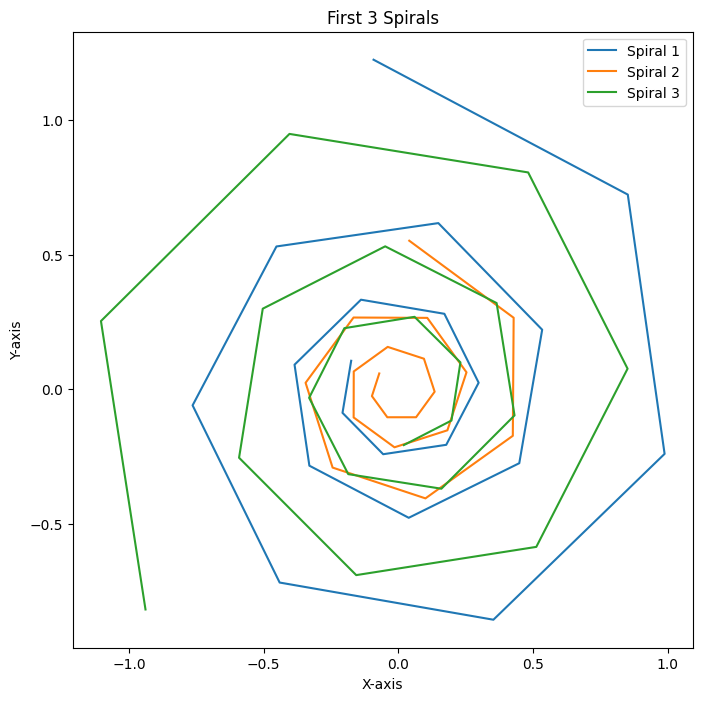

In [10]:
#visulize spirals
plt.figure(figsize=(8, 8))
for i in range(3):
    spiral = spirals_cw[:, i, :].detach().numpy()  # Extract and convert to NumPy
    plt.plot(spiral[:, 0], spiral[:, 1], label=f"Spiral {i+1}")

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("First 3 Spirals")
plt.legend()
plt.axis("equal")  # Keep aspect ratio 1:1
plt.show()

In [12]:
from torch.utils.data import DataLoader, TensorDataset

def get_dataloader(datapoints, batch_size=32, shuffle=True):
    """
    Returns a PyTorch DataLoader for batching spiral data.
    
    Args:
        spirals (torch.Tensor): Tensor of shape (n_points, num_spirals, 2).
        batch_size (int): Number of spirals per batch.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        DataLoader: PyTorch DataLoader that yields batches of shape (batch_size, n_points, 2).
    """
    # Swap dimensions to match (num_spirals, n_points, 3) for batching
    datapoints = datapoints.permute(1, 0, 2)  # (1000, 100, 3)

    # Create dataset and dataloader
    dataset = TensorDataset(datapoints)  # Wrap spirals in a dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [12]:
batch_size = 128
dataloader = get_dataloader(datapoints, batch_size=batch_size)
for batch in dataloader:
    print(len(batch))
    print(batch[0].shape)
    break

1
torch.Size([128, 20, 3])


In [9]:
#ode network for latent dynamics, architecture mimics code from original paper
#make it time invariant to allow generation and extrapolation from a sampled latent variable, without having to specify a time
class LatentODENet(ODEF):
    def __init__(self, latent_dim=4, hidden_size=20):
        super(LatentODENet, self).__init__()
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(latent_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, latent_dim)

    def forward(self, z, t):
        z = self.elu(self.fc1(z))
        z = self.elu(self.fc2(z))
        z = self.fc3(z)
        return z

In [14]:
spiral_func = LatentODENet(2, 50)
spiral_ode = NeuralODE(spiral_func)
if use_cuda:
    spiral_ode.cuda()

In [15]:
optimizer = torch.optim.AdamW(spiral_ode.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [16]:
def train_spirals_regr(epochs):
    for epoch in range(epochs):
        spiral_ode.train()
        total_loss=0
        for batch in dataloader:
            b = batch[0]
            x = b[:, :, :2]
            x0 = b[:,0,:2]
            t = b[0, :, 2]
            if use_cuda:
                x = x.cuda()
                x0 = x0.cuda()
                t = t.cuda()
            optimizer.zero_grad()
            x_rec = spiral_ode(x0, t, return_whole_sequence=True)
            x_rec = x_rec.permute(1,0,2)
            loss = F.mse_loss(x_rec, x, reduction='none').sum(-1).sum(-1)
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()

        total_loss = total_loss/(1000//batch_size)
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss:.4f}")
        
        #plot to monitor evolution
        if epoch % 50 == 0:
            spiral_ode.eval()
            with torch.no_grad():
                sample_batch = next(iter(dataloader))[0]
                x_sample = sample_batch[:, :, :2]
                x0_sample = sample_batch[:,0,:2]  
                t_sample = sample_batch[0, :, 2]  
                if use_cuda:
                    x_sample, x0_sample, t_sample = x_sample.cuda(), x0_sample.cuda(), t_sample.cuda()

                x_rec_sample = spiral_ode(x0_sample, t_sample, return_whole_sequence=True)
                x_rec_sample = x_rec_sample.permute(1,0,2)

            x_sample, x_rec_sample = x_sample.cpu().numpy(), x_rec_sample.cpu().numpy()

            # Plot Original Spirals
            plt.figure(figsize=(6, 6))
            plt.title("Original vs Reconstructed")
            plt.plot(x_sample[0,:, 0], x_sample[0,:, 1], label=f"Original Spiral")

            # Plot Reconstructed Spirals 
            plt.plot(x_rec_sample[0, :, 0], x_rec_sample[0, :, 1], label=f"Reconstructed Spiral")
            plt.legend()
            plt.xlabel("x")
            plt.ylabel("y")
            plt.show()
        
        scheduler.step(total_loss)
                


Epoch [1/60] | Loss: 28.0032


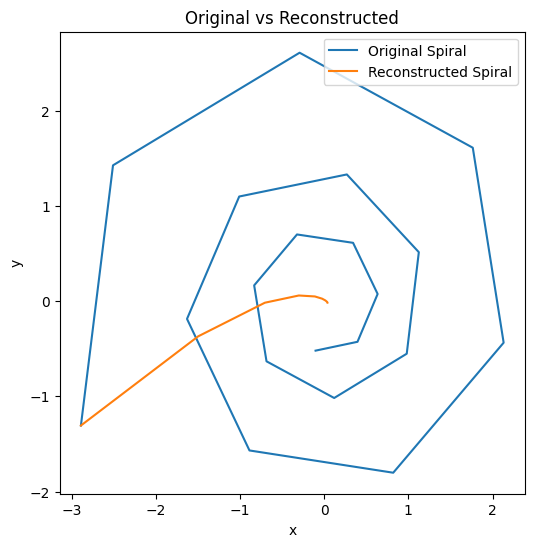

Epoch [11/60] | Loss: 4.9846
Epoch [21/60] | Loss: 4.7955
Epoch [31/60] | Loss: 4.1266
Epoch [41/60] | Loss: 0.6764
Epoch [51/60] | Loss: 0.2010


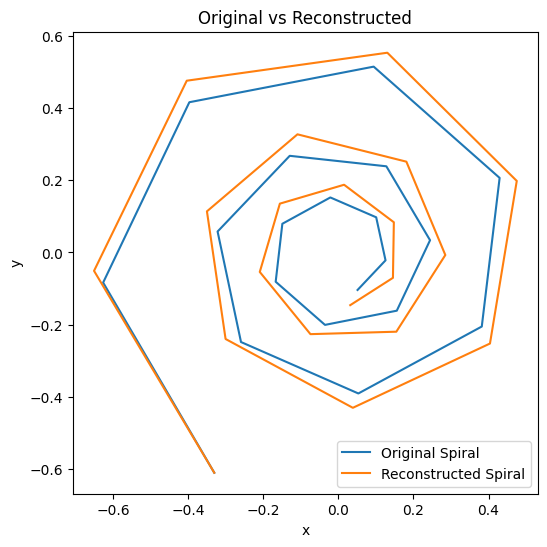

In [17]:
train_spirals_regr(60)

Very well, the model can fit the trajectories fairly easily. 
Now, let's generate a mix of cloclwise and counterclockwise spirals and fit an OdeVAE to that dataset.

To showcase the potential of NeuralODEs to process irregularly sampled time series, we're gonna generate the full trajectories (100 points) and then sample shorter sequences from them, at irregular intervals

Dataset generation

In [10]:
num_spirals = 1000
n_points = 100
n_sample = 20
t_max = 6.28 * 5
noise_std = 0.02

#generate full trajectories, sampling will be done in the training loop for easier monitoring 
t = torch.linspace(0, t_max, n_points).unsqueeze(1)
normal01 = torch.distributions.Normal(0, 1.)
z0 = Variable(normal01.sample((num_spirals, 2)))

traj_cw = cw_spiral(z0[:500], t, return_whole_sequence=True)
traj_cc = cc_spiral(z0[500:], t, return_whole_sequence=True) 
traj = torch.cat((traj_cw, traj_cc), dim=1)
traj = traj + torch.randn_like(traj)*noise_std

#spirals = torch.zeros(n_sample, num_spirals, 2)
#times = torch.zeros(n_sample, num_spirals, 1) # (T, B, C)
times = t.expand(-1, num_spirals).unsqueeze(-1)  # (T, B, C)

print(traj.shape)  # Expected output: torch.Size([T, B, C])
print(times.shape)

datapoints = torch.cat((traj, times), dim=-1).detach()  # (T, B, C)


torch.Size([100, 1000, 2])
torch.Size([100, 1000, 1])


In [13]:
#generate batches
batch_size = 32
dataloader = get_dataloader(datapoints, batch_size=batch_size)
for batch in dataloader:
    print(len(batch))
    print(batch[0].shape)
    break

1
torch.Size([32, 100, 3])


Build OdeVAE

In [14]:
#rnn encoder
class RnnEncoder(nn.Module):
    def __init__(self, input_dim, hidden_size=20, latent_dim=4):
        super().__init__()
        self.i2h = nn.Linear(input_dim + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, latent_dim*2)
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
    
    def forward(self, x, t):
        len = x.shape[1]
        h = self.initHidden(x).to(x.device)
        for t in reversed(range(len)):
            xt = x[:,t,:]
            xh = torch.cat((xt, h), dim=1)
            h = torch.tanh(self.i2h(xh))
        out = self.h2o(h)
        mu = out[:,: self.latent_dim]
        logvar = out[:, self.latent_dim:]
        #print(f'mu shape: {mu.shape}, logvar shape: {logvar.shape}')
        return mu, logvar

    def initHidden(self, x):
        batch_size = x.shape[0]
        return torch.zeros(batch_size, self.hidden_size)

In [15]:
#neural ode decoder
class NeuralODEDecoder(nn.Module):
    def __init__(self, out_dim, hidden_size, latent_dim=4):
        super(NeuralODEDecoder, self).__init__()
        self.out_dim = out_dim
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        func = LatentODENet(latent_dim, hidden_size)
        self.ode = NeuralODE(func)
        self.fc1 = nn.Linear(latent_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)
        self.relu = nn.ReLU()

    def forward(self, z0, t):
        z = self.ode(z0, t, return_whole_sequence=True)
        #print(f'Shape after ode: {z.shape}')
        z = self.fc1(z)
        z = self.relu(z)
        x = self.fc2(z)
        #print(f'Shape after decoder: {x.shape}')
        return x
    

In [23]:
#define the VAE
class VAE(nn.Module):
    def __init__(self, out_dim, hidden_size, latent_dim=4):
        super(VAE, self).__init__()
        self.out_dim = out_dim
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.encoder = RnnEncoder(out_dim, hidden_size, latent_dim)
        self.decoder = NeuralODEDecoder(out_dim, hidden_size, latent_dim)

    def forward(self, x, t):
        z_mean, z_logvar = self.encoder(x, t)
        z = z_mean + torch.exp(0.5 * z_logvar) * torch.randn_like(z_mean)
        #print(f'Shape of z before decoder: {z.shape}')
        x = self.decoder(z, t)
        x = x.permute(1,0,2)
        return x, z, z_mean, z_logvar
    
    def generate(self, seed, t): #time dimension of seed and length of t don't need to match
        len = seed.shape[1]
        z_mean, z_logvar = self.encoder(seed, t[:len])
        x = self.decoder(z_mean, t)
        return x

Training the VAE

In [24]:
vae = VAE(out_dim=2, hidden_size=64, latent_dim=8)
if use_cuda:
    vae = vae.cuda()
print(sum(p.numel() for p in vae.parameters())/1e6, 'M parameters')

0.01129 M parameters


In [18]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


In [19]:
def train(epochs=1000):

  def vae_loss(x_rec, x, mu, logvar, beta):
    rec_loss = F.mse_loss(x_rec, x, reduction='none').sum(-1).sum(-1) #mse loss beacause gaussian assumption for p(x|z)
    rec_loss = rec_loss.mean()
    #using mean instead of sum as dim reduction to avoid scaling with batch size and keep gradient magnitudes stable
    kl_loss = -0.5 * torch.sum(1 + logvar - mu*mu - torch.exp(logvar), -1)
    kl_loss = kl_loss.mean()
    return rec_loss + beta*kl_loss, rec_loss, kl_loss

  def kl_annealing(epoch, total_epochs, min_beta=0.1, max_beta=1.0):
    t = torch.tensor(epoch / total_epochs * 12 - 6, dtype=torch.float32) # Shifted sigmoid
    return min_beta + (max_beta - min_beta) / (1 + torch.exp(-t))


  previous_kl = float('inf')
  previous_recon = float('inf')

  for epoch in range(epochs):   

    vae.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    for batch in dataloader:
      b = batch[0]
      x = b[:, :, :2]
      t = b[0, :, 2]
      if use_cuda:
        x = x.cuda()
        t = t.cuda()
      permutation = np.random.permutation(n_points)
      permutation = np.sort(permutation[:n_sample])  # Random non-consecutive indices
      x = x[:, permutation, :]  # Sample correctly
      t = t[permutation]
      #t[1:] = t[1:] - t[:-1]
      #t[0] = 0.
      optimizer.zero_grad()
      x_rec, z, z_mean, z_logvar = vae(x, t)
      #if epoch == 0:
      #  print(f'x_rec: {x_rec.shape}, x: {x.shape}')
      beta = kl_annealing(epoch, epochs)
      loss, recon, kl = vae_loss(x_rec, x, z_mean, z_logvar, beta)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      total_recon += recon.item()
      total_kl += kl.item()
    total_loss = total_loss/(1000//batch_size)
    total_recon = total_recon/(1000//batch_size)
    total_kl = total_kl/(1000//batch_size)
    if (abs(previous_kl - total_kl) < 5e-4 ) and (abs(previous_recon - total_recon) < 5e-4) :
      print(f'Stopped at epoch {epoch}') #early stopping
      print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss:.4f} | Recon: {total_recon:.4f} | KL: {total_kl:.4f}")
      break
    previous_kl = total_kl
    previous_recon = total_recon
    if epoch % 10 == 0:
      print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss:.4f} | Recon: {total_recon:.4f} | KL: {total_kl:.4f}")
    scheduler.step(total_recon)

    #plot to monitor evolution
    if epoch % 50 == 0:
      vae.eval()
      with torch.no_grad():
          sample_batch = next(iter(dataloader))[0]
          x_sample = sample_batch[:, :, :2]  
          t_sample = sample_batch[0, :, 2]  
          if use_cuda:
            x_sample, t_sample = x_sample.cuda(), t_sample.cuda()

          x_rec_sample, _, _, _ = vae(x_sample, t_sample)

      x_sample, x_rec_sample = x_sample.cpu().numpy(), x_rec_sample.cpu().numpy()

      # Plot Original Spirals
      plt.figure(figsize=(6, 6))
      plt.title("Original vs Reconstructed")
      plt.plot(x_sample[0, :, 0], x_sample[0, :, 1], label=f"Original Spiral")

      # Plot Reconstructed Spirals 
      plt.plot(x_rec_sample[0, :, 0], x_rec_sample[0, :, 1], label=f"Reconstructed Spiral")
      plt.legend()
      plt.xlabel("x")
      plt.ylabel("y")
      plt.show()
      

Epoch [1/200] | Loss: 10.9539 | Recon: 10.9280 | KL: 0.2535


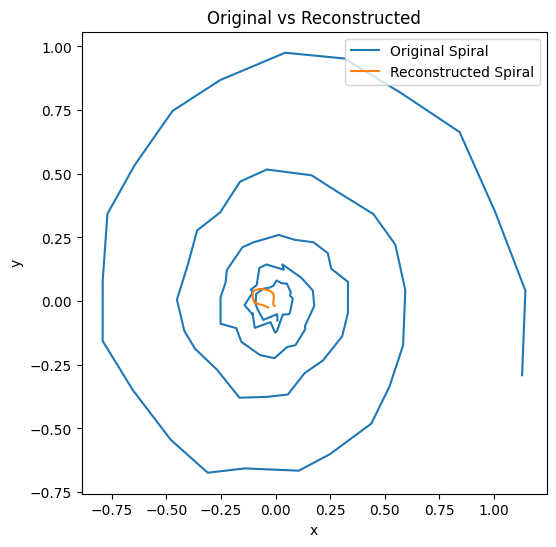

Epoch [11/200] | Loss: 6.1426 | Recon: 5.6854 | KL: 4.3937
Epoch [21/200] | Loss: 4.6625 | Recon: 3.9608 | KL: 6.5368
Epoch [31/200] | Loss: 3.2457 | Recon: 2.4026 | KL: 7.4419
Epoch [41/200] | Loss: 3.0387 | Recon: 2.1466 | KL: 7.1974
Epoch [51/200] | Loss: 2.5860 | Recon: 1.6224 | KL: 6.7535


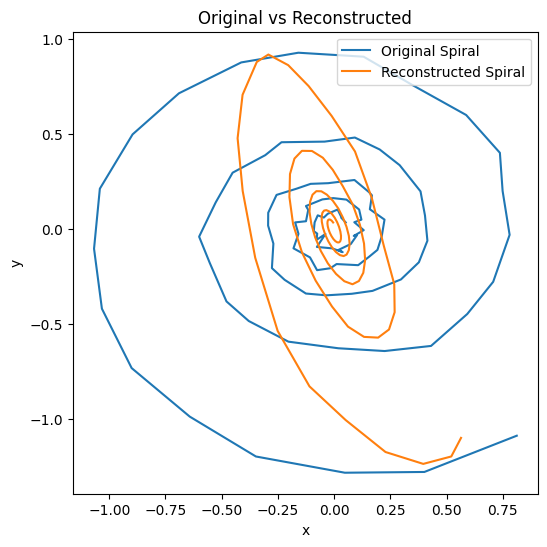

Epoch [61/200] | Loss: 3.6291 | Recon: 2.4707 | KL: 6.6246
Epoch [71/200] | Loss: 2.8830 | Recon: 1.4522 | KL: 6.2846
Epoch [81/200] | Loss: 3.9144 | Recon: 1.8940 | KL: 6.5526
Epoch [91/200] | Loss: 4.5691 | Recon: 1.8188 | KL: 6.5653
Epoch [101/200] | Loss: 5.2402 | Recon: 1.6659 | KL: 6.4987


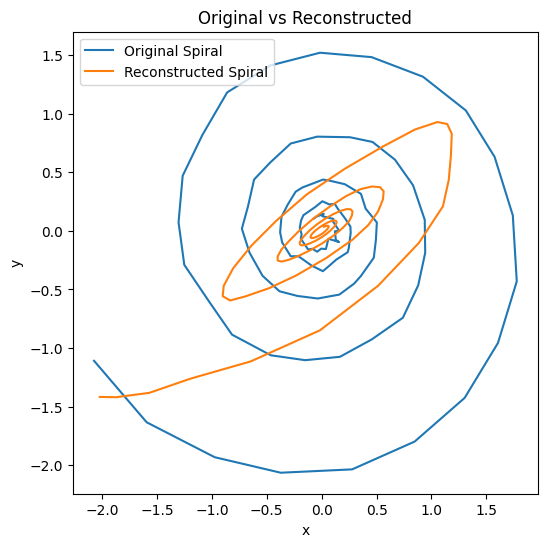

Epoch [111/200] | Loss: 6.2474 | Recon: 1.9572 | KL: 6.2991
Epoch [121/200] | Loss: 6.9923 | Recon: 1.9370 | KL: 6.3856
Epoch [131/200] | Loss: 7.0687 | Recon: 1.6489 | KL: 6.2129
Epoch [141/200] | Loss: 8.1024 | Recon: 2.2201 | KL: 6.3583
Epoch [151/200] | Loss: 8.3821 | Recon: 2.2067 | KL: 6.4507


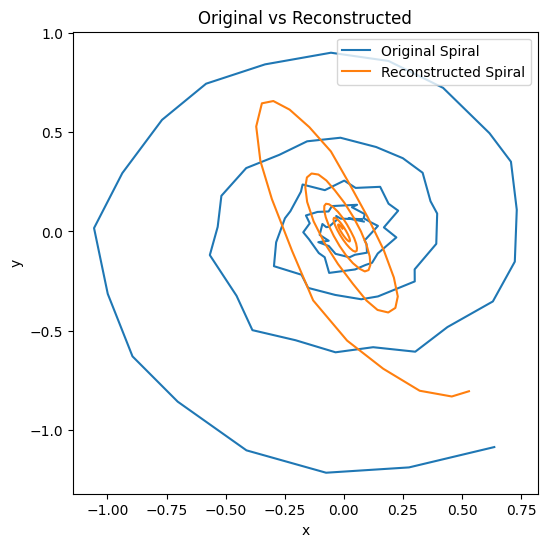

Epoch [161/200] | Loss: 7.8670 | Recon: 1.7309 | KL: 6.2866
Epoch [171/200] | Loss: 8.3794 | Recon: 2.2137 | KL: 6.2487
Epoch [181/200] | Loss: 7.9156 | Recon: 1.6750 | KL: 6.2868
Epoch [191/200] | Loss: 8.2423 | Recon: 1.9025 | KL: 6.3656


In [63]:
train(epochs=200)

In [64]:
torch.save(vae.state_dict(), "vae_model.pth")

In [20]:
vae.load_state_dict(torch.load("vae_model.pth"))

<All keys matched successfully>

Epoch [1/100] | Loss: 3.4308 | Recon: 2.7485 | KL: 6.6746


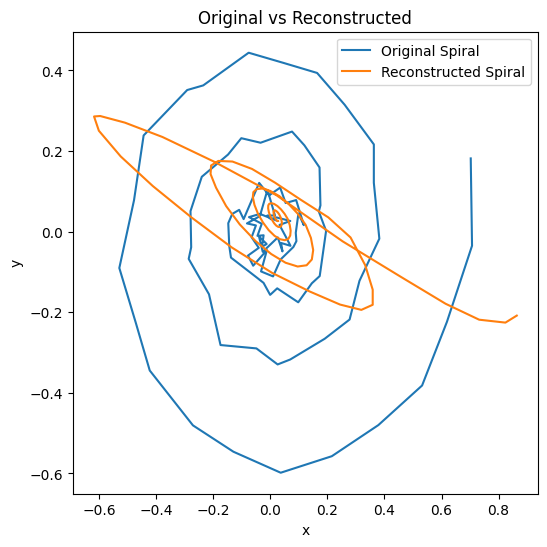

Epoch [11/100] | Loss: 2.4127 | Recon: 1.6683 | KL: 6.9349
Epoch [21/100] | Loss: 2.4143 | Recon: 1.6234 | KL: 6.3812
Epoch [31/100] | Loss: 2.4952 | Recon: 1.4642 | KL: 5.8962
Epoch [41/100] | Loss: 3.1234 | Recon: 1.5386 | KL: 5.1397
Epoch [51/100] | Loss: 3.9903 | Recon: 1.2823 | KL: 4.9235


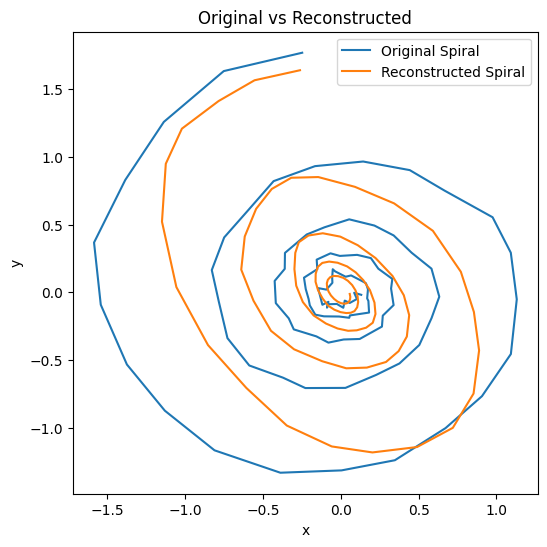

Epoch [61/100] | Loss: 5.0057 | Recon: 1.2119 | KL: 4.7921
Epoch [71/100] | Loss: 5.6552 | Recon: 1.1732 | KL: 4.8446
Epoch [81/100] | Loss: 6.5066 | Recon: 1.7989 | KL: 4.8231
Epoch [91/100] | Loss: 6.4252 | Recon: 1.6773 | KL: 4.7831


In [21]:
train(epochs=100)

In [22]:
torch.save(vae.state_dict(), "vae_model_300_epochs.pth")

In [25]:
vae.load_state_dict(torch.load("vae_model_300_epochs.pth"))

<All keys matched successfully>

recon shape: torch.Size([100, 1, 2])
recon shape numpy: (1, 100, 2)


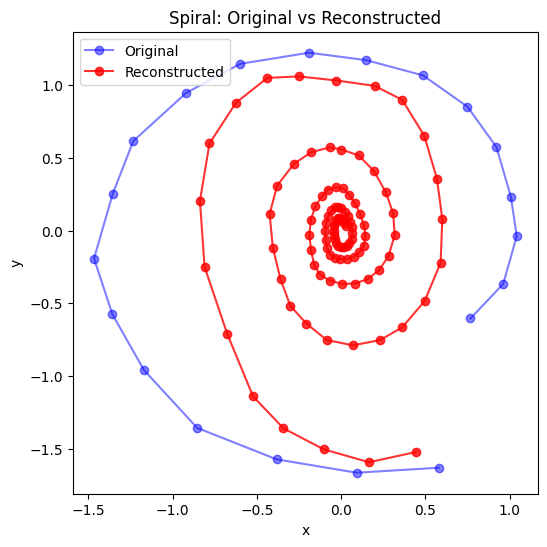

In [33]:
for batch in dataloader:
    b = batch[0]
    x = b[0, :, :2]
    t = b[0, :, 2]
    if use_cuda:
        x = x.cuda()
        t = t.cuda()
    vae.eval()  # Set model to evaluation mode
    x = x.unsqueeze(0)
    x = x[:,:n_sample, :]
    with torch.no_grad():
        recon = vae.generate(x, t)

    print(f'recon shape: {recon.shape}')    
    recon = recon.permute(1, 0, 2).squeeze(1)  # (100, 1, 2)
    #print(f'recon shape after permutation: {recon.shape}')
    #recon = recon * std.cuda() + mean.cuda()
    #recon = recon.squeeze(0)
    #print(f'recon shape after scaling: {recon.shape}')
    reconstructed_spiral = recon.cpu().numpy()
    original_spiral = x.cpu().numpy()
    print(f'recon shape numpy: {reconstructed_spiral.shape}')

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(original_spiral[0,:, 0], original_spiral[0, :, 1], 'bo-', label="Original", alpha=0.5)
    plt.plot(reconstructed_spiral[0, :, 0], reconstructed_spiral[0,:, 1], 'ro-', label="Reconstructed", alpha=0.8)
    plt.legend()
    plt.title(f"Spiral: Original vs Reconstructed")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    break


As you can see, we are able to generate a longer sequence from a short seed. Due to limited computational resources, the number of training epochs used is a tenth of the original implementation, so the VAE doesn't reconstruct the spirals perfectly, but it generates spirals with the right rotation and that are reasonably close to the original.